In [2]:
import numpy as np
import pandas as pd
import xpress as xp


## Data Exploration

In [4]:
# read-data
TransactionsInput = pd.read_excel("231013_Transactions_Input.xlsx")

In [5]:
FuardCases = pd.read_excel("231013_Fraud_Cases.xlsx")
CustomerBase = pd.read_excel("231013_Customer_Base.xlsx")

In [6]:
TransactionsInput["description"].nunique()

347

In [7]:
TransactionsInput

,transaction_id,description,Amount,category,date,month,customer_id,type,In_or_Out,bank_to,bank_from,transac_prob,description_prob,priority
0,1,Salary Deposit - XYZ Corporation,11474.33021,Income,2023-10-01,October,17699,income,paid_in,bank_A,bank_A,NaN,NaN,3
1,2,Online Retailer - Electronics Purchase,199.99000,Online Shopping,2023-10-01,October,10298,spending,paid_out,bank_A,bank_E,0.78,0.25,3
2,3,Utilities Payment - Internet Service,60.00000,Utilities,2023-10-01,October,10298,spending,paid_out,bank_C,bank_E,0.30,0.22,1
3,4,Rent Payment,1500.00000,Housing,2023-10-01,October,14507,spending,paid_out,bank_D,bank_E,0.57,0.53,3
4,5,Paycheck Deposit - Company Name,10480.68449,Income,2023-10-01,October,14507,income,paid_in,bank_E,bank_D,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315177,315178,Grocery Shopping - Super Value Mart,55.25000,Groceries,2024-07-31,July,15026,spending,paid_out,bank_C,bank_B,0.42,0.17,1
315178,315179,JCPenney - Discount Fashion,40.00000,Shopping,2024-07-31,July,11908,spending,paid_out,bank_D,bank_A,0.36,0.36,1
315179,315180,Gas Station - Fuel Purchase,40.45000,Transportation,2024-07-31,July,10291,spending,paid_out,bank_D,bank_D,0.28,0.64,1
315180,315181,ATM Withdrawal - PQR Bank ATM,80.00000,Cash Withdrawal,2024-07-31,July,18543,spending,paid_out,NaN,bank_A,0.24,0.23,2


In [8]:
CustomerBase

,customer_id,home_bank,customer_prob
0,10298,bank_E,0.49
1,14507,bank_E,0.35
2,14558,bank_E,0.45
3,13453,bank_E,0.63
4,19629,bank_D,0.79
...,...,...,...
480,15364,bank_E,0.42
481,13462,bank_A,0.53
482,18020,bank_E,0.38
483,16643,bank_B,0.26


In [9]:
TransactionsInput_clean = TransactionsInput.drop('description_prob', axis=1)

In [10]:
FuardCases

,transaction_id,is_scam_transaction,fraud_type,case_id
0,187,1,AdvanceFee,5415844
1,247,1,Impersonation,4280670
2,818,1,Impersonation,6956462
3,891,1,Purchase,2702984
4,1142,1,Purchase,3493741
...,...,...,...,...
2476,313591,1,Impersonation,5711663
2477,314245,1,AdvanceFee,8032096
2478,314259,1,Purchase,1154155
2479,314411,1,AdvanceFee,4460117


### Find the seasonality

In [11]:
Fuard_time = pd.merge(TransactionsInput,FuardCases, on="transaction_id")[["date","month"]]
Fuard_time['month'] = Fuard_time.apply(lambda row: row['month'] + str(row['date'].year), axis=1)
unique_date, counts_date = np.unique(Fuard_time[['date']], return_counts=True)
unique_month, counts_month = np.unique(Fuard_time[['month']], return_counts=True)
frequency_date = dict(zip(unique_date, counts_date))
frequency_month = dict(zip(unique_month, counts_month))  
print(frequency_date)
print(frequency_month)

{numpy.datetime64('2023-10-01T00:00:00.000000000'): 18, numpy.datetime64('2023-10-02T00:00:00.000000000'): 6, numpy.datetime64('2023-10-03T00:00:00.000000000'): 20, numpy.datetime64('2023-10-04T00:00:00.000000000'): 7, numpy.datetime64('2023-10-05T00:00:00.000000000'): 8, numpy.datetime64('2023-10-06T00:00:00.000000000'): 8, numpy.datetime64('2023-10-07T00:00:00.000000000'): 4, numpy.datetime64('2023-10-08T00:00:00.000000000'): 8, numpy.datetime64('2023-10-09T00:00:00.000000000'): 9, numpy.datetime64('2023-10-10T00:00:00.000000000'): 6, numpy.datetime64('2023-10-11T00:00:00.000000000'): 5, numpy.datetime64('2023-10-12T00:00:00.000000000'): 13, numpy.datetime64('2023-10-13T00:00:00.000000000'): 7, numpy.datetime64('2023-10-14T00:00:00.000000000'): 8, numpy.datetime64('2023-10-15T00:00:00.000000000'): 9, numpy.datetime64('2023-10-16T00:00:00.000000000'): 6, numpy.datetime64('2023-10-17T00:00:00.000000000'): 6, numpy.datetime64('2023-10-18T00:00:00.000000000'): 8, numpy.datetime64('2023-1

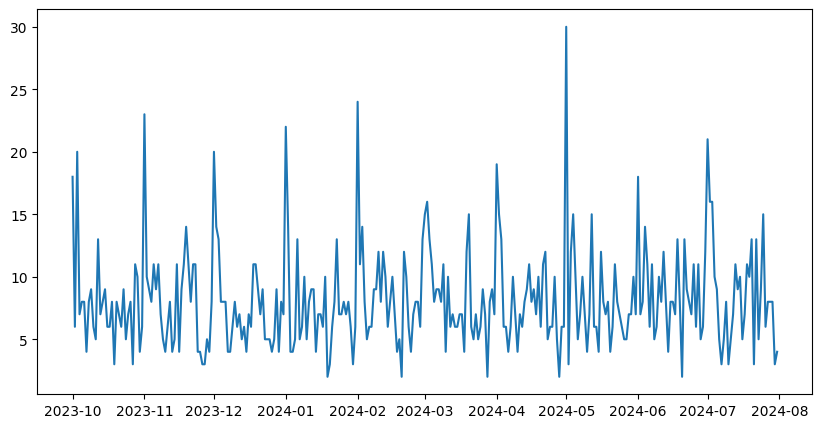

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(unique_date,counts_date)

In [20]:
# in proportion
TransactionsInput['if_fraud'] = TransactionsInput['transaction_id'].apply(lambda x: 1 if x in FuardCases['transaction_id'].values else 0)
TransactionsInput_ratio = TransactionsInput[["date","if_fraud"]]


In [32]:
label_ratio = TransactionsInput_ratio.groupby('date')['if_fraud'].mean()
label_ratio

date
2023-10-01    0.007453
2023-10-02    0.004386
2023-10-03    0.014524
2023-10-04    0.006162
2023-10-05    0.008584
                ...   
2024-07-27    0.008621
2024-07-28    0.008547
2024-07-29    0.009313
2024-07-30    0.003036
2024-07-31    0.004264
Name: if_fraud, Length: 305, dtype: float64

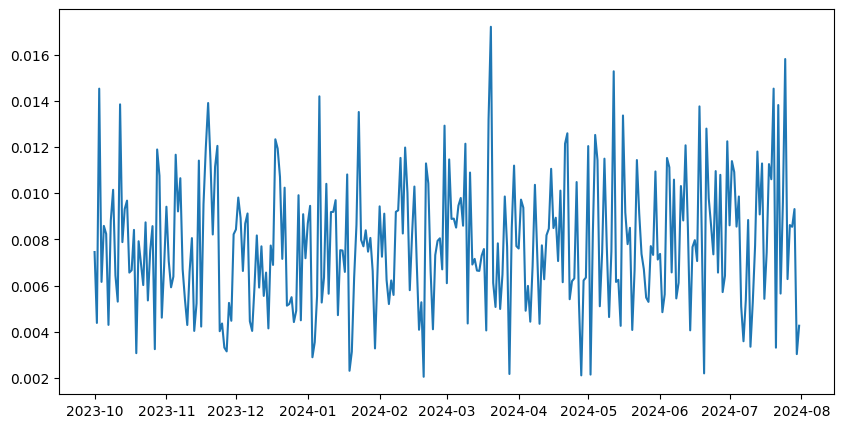

In [33]:
plt.figure(figsize=(10,5))
plt.plot(unique_date,label_ratio)

In [ ]:
# TransactionsInput_clean = TransactionsInput_clean[["In_or_Out"] == "paid_in"]

## Create a problem with xpress module

#### The basic model in a single day. (Ignore the learn model)

In [ ]:
# just use for testing
customer_num = 10

### Abstract the test set for testing the code - only use first 10 transactios

In [ ]:
TransactionsInput_clean_test = TransactionsInput_clean[0:10]
TransactionsInput_clean_test

,transaction_id,description,Amount,category,date,month,customer_id,type,In_or_Out,bank_to,bank_from,transac_prob,priority
0,1,Salary Deposit - XYZ Corporation,11474.33021,Income,2023-10-01,October,17699,income,paid_in,bank_A,bank_A,NaN,3
1,2,Online Retailer - Electronics Purchase,199.99000,Online Shopping,2023-10-01,October,10298,spending,paid_out,bank_A,bank_E,0.78,3
2,3,Utilities Payment - Internet Service,60.00000,Utilities,2023-10-01,October,10298,spending,paid_out,bank_C,bank_E,0.30,1
3,4,Rent Payment,1500.00000,Housing,2023-10-01,October,14507,spending,paid_out,bank_D,bank_E,0.57,3
4,5,Paycheck Deposit - Company Name,10480.68449,Income,2023-10-01,October,14507,income,paid_in,bank_E,bank_D,NaN,3
5,6,Online Retailer - Electronics Purchase,299.99000,Online Shopping,2023-10-01,October,14507,spending,paid_out,bank_E,bank_E,0.75,3
6,7,Asos - Online Fashion Shopping,55.00000,Shopping,2023-10-01,October,14507,spending,paid_out,bank_B,bank_E,0.37,1
7,8,Transfer from Savings to Current,175.00000,Transfers,2023-10-01,October,14507,income,paid_in,bank_E,bank_E,NaN,3
8,9,Fuel Purchase - Gas Station,42.75000,Transportation,2023-10-01,October,14507,spending,paid_out,bank_E,bank_E,0.39,1
9,10,Fuel Purchase - Gas Station,45.60000,Transportation,2023-10-01,October,14507,spending,paid_out,bank_A,bank_E,0.24,1


In [ ]:
# data (parameeters) needed in this problem
# NOTE THAT: very strightforward way in this case as this is the idea stage.
# still need to abstract the single instead of a whole data set
x_length = len(TransactionsInput_clean_test["transaction_id"])
y_length = len(TransactionsInput_clean_test["transaction_id"])
Prob_transac = TransactionsInput_clean_test["transac_prob"]
# Prob_description = TransactionsInput_clean_test["description_prob"]  

Customer_test = pd.merge(TransactionsInput_clean_test, CustomerBase, on="customer_id", how="left")[['transaction_id','customer_id','home_bank','customer_prob']]
Prob_customer = Customer_test["customer_prob"]

# bank here is used to distribute the investigation resiponsibility
Bank_to = TransactionsInput_clean_test["bank_to"]
Bank_from = TransactionsInput_clean_test["bank_from"]


# Parameters
Bank = ["A", "B", "C", "D", "E"]
Investigarion_team = [8, 12, 10, 10, 10]

Priority = [1,2,3,4]
Investigation_time = [0.25, 0.5, 1, 2]
Investigation_hire_exter = [40, 60, 100, 150]
Investigation_success = [0.5, 0.6, 0.7, 0.8]


In [ ]:
# test
Customer_test

,transaction_id,customer_id,home_bank,customer_prob
0,1,17699,bank_A,0.66
1,2,10298,bank_E,0.49
2,3,10298,bank_E,0.49
3,4,14507,bank_E,0.35
4,5,14507,bank_E,0.35
5,6,14507,bank_E,0.35
6,7,14507,bank_E,0.35
7,8,14507,bank_E,0.35
8,9,14507,bank_E,0.35
9,10,14507,bank_E,0.35


In [ ]:
# Create a problem called transaction

prob = xp.problem(name='transaction') 

Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('D:/APP/Xpress/bin/xpauth.xpr')


In [ ]:
# Create the x variables
x = xp.var(vartype=xp.binary, name="x") # if we want to investigate the transaction i
f = xp.var(vartype=xp.binary, name="f") # if the in vestigation label transaction i is fraud
y = xp.var(vartype=xp.binary, name="y") #

# Add the variables to the problem
# can only add once. If run the code without cleaning menory, will report error.
prob.addVariable(x,f,y)

### how can i define the shape of variable like xpress

In [ ]:
# add objective value
# expect value on investigation cost
prob.addObjective(i for i in x_length x[i]*)

In [ ]:
# add constraints
prob.addConstraint()